In [1]:
import calendar
import cPickle as cPickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import xgboost
%matplotlib inline

/Users/richard/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# reading in data

In [2]:
df = pd.read_csv('LoanStats3a.csv', header=1)
df.head()

/Users/richard/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
len(df)

42538

In [4]:
df.columns

Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
       u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
       ...
       u'hardship_payoff_balance_amount', u'hardship_last_payment_amount',
       u'disbursement_method', u'debt_settlement_flag',
       u'debt_settlement_flag_date', u'settlement_status', u'settlement_date',
       u'settlement_amount', u'settlement_percentage', u'settlement_term'],
      dtype='object', length=145)

# cleaning data

In [5]:
# drop rows and columns with a lot of missing data
df = df.loc[df.index, df.count(0) > df.shape[0] * 0.9] # drop columns with more than 10% empty data
df = df.dropna(axis=0, how='all')
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N


In [6]:
df.shape

(42535, 53)

## dropping columns that can't or won't be used

In [7]:
nunique = df.apply(pd.Series.nunique) 
df = df.drop(nunique[nunique == 1].index, axis=1) # drop columns with only one unique value
df = df.drop(['total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', # these are recorded after the loan, so drop
              'total_rec_int', 'total_rec_late_fee', 'recoveries', 
              'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
              'last_credit_pull_d', 'acc_now_delinq', 'delinq_amnt', 'debt_settlement_flag'], axis=1)

df = df.drop(['emp_title', 'title', 'zip_code', 'funded_amnt_inv', 'loan_amnt'], 
             axis=1) # drop employer, reason for loan, user's loan title, zip code

df = df.loc[df.count(1) > df.shape[1] * 0.7, df.columns] # drop rows with more than 30% empty data

df.head()

,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,tax_liens
0,5000.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,24000.0,Verified,...,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,0.0,0.0
1,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,...,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,0.0,0.0
2,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,...,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,0.0,0.0
3,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,...,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,0.0,0.0
4,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,80000.0,Source Verified,...,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9%,38.0,0.0,0.0


## cleaning remaining columns

In [8]:
df.term = df.term.str[:-7].astype(int) # drop "months" from term
df.int_rate = df.int_rate.str[:-1].astype(float) # drop percent sign from term
df.revol_util = df.revol_util.str[:-1].astype(float) # drop percent sign from term
df.loan_status = df.loan_status.str.replace('Does not meet the credit policy. Status:', 
                                            '') # drop unnecessary info from loan status
df.head()

,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,tax_liens
0,5000.0,36,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,...,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,0.0,0.0
1,2500.0,60,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,...,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4,4.0,0.0,0.0
2,2400.0,36,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,...,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,0.0,0.0
3,10000.0,36,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,...,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21.0,37.0,0.0,0.0
4,3000.0,60,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,...,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9,38.0,0.0,0.0


In [9]:
for var in ['revol_util', 'total_acc', 'pub_rec_bankruptcies', 'tax_liens']:
    df[var] = df[var].replace(np.nan, 0)

In [10]:
df.shape

(42506, 25)

In [11]:
df.columns

Index([u'funded_amnt', u'term', u'int_rate', u'installment', u'grade',
       u'sub_grade', u'emp_length', u'home_ownership', u'annual_inc',
       u'verification_status', u'issue_d', u'loan_status', u'purpose',
       u'addr_state', u'dti', u'delinq_2yrs', u'earliest_cr_line',
       u'inq_last_6mths', u'open_acc', u'pub_rec', u'revol_bal', u'revol_util',
       u'total_acc', u'pub_rec_bankruptcies', u'tax_liens'],
      dtype='object')

### convert some variables to numerical
#### ['grade', 'sub_grade', 'emp_length', 'issue_d', 'earliest_cr_line']

In [12]:
# convert grade and subgrade to numerical values
df.grade = df.grade.apply(ord) - 64
df.sub_grade = df.grade + df.sub_grade.str[1].apply(int) / 10.

In [13]:
df.emp_length.unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan], dtype=object)

In [14]:
df['has_employment'] = df.emp_length.notnull().astype(int)
df.emp_length = df.emp_length.replace('n/a', '0')
df.emp_length = df.emp_length.replace(np.nan, '0')
df.emp_length = df.emp_length.replace('\+? ?years?', '', regex=True)
df.emp_length = df.emp_length.replace('< 1', '0')
df.emp_length = pd.to_numeric(df.emp_length)

In [15]:
months = {v: k for k,v in enumerate(calendar.month_abbr)}
def get_month_number(abbr):
    return months[abbr]

In [16]:
df['issue_month'] = df.issue_d.str[:3].apply(get_month_number) # convert issue date to numerical values
df['issue_year'] = df.issue_d.str[-2:].astype(int)
df = df.drop(['issue_d'], axis=1)

In [17]:
df['earliest_cr_line_month'] = df.earliest_cr_line.str[:3].apply(get_month_number) # convert issue date to numerical values
df['earliest_cr_line_year'] = df.earliest_cr_line.str[-4:].astype(int)
df = df.drop(['earliest_cr_line'], axis=1)

## add dummies

In [18]:
for var in ['home_ownership', 'purpose', 'verification_status']:#, 'addr_state']: # dummies
    dummies = pd.get_dummies(df[var], prefix=var, drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop([var], axis=1)

In [19]:
df = df.drop(['addr_state'], axis=1)

In [20]:
df.head()

,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,loan_status,dti,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,verification_status_Source Verified,verification_status_Verified
0,5000.0,36,10.65,162.87,2,2.2,10,24000.0,Fully Paid,27.65,...,0,0,0,0,0,0,0,0,0,1
1,2500.0,60,15.27,59.83,3,3.4,0,30000.0,Charged Off,1.00,...,0,0,0,0,0,0,0,0,1,0
2,2400.0,36,15.96,84.33,3,3.5,10,12252.0,Fully Paid,8.72,...,0,0,0,0,0,1,0,0,0,0
3,10000.0,36,13.49,339.31,3,3.1,10,49200.0,Fully Paid,20.00,...,0,0,0,1,0,0,0,0,1,0
4,3000.0,60,12.69,67.79,2,2.5,1,80000.0,Fully Paid,17.94,...,0,0,0,1,0,0,0,0,1,0


In [21]:
df.to_csv('LoanStats3a_cleaned.csv')

# read in clean data

In [22]:
df = pd.read_csv('LoanStats3a_cleaned.csv', index_col=0)
df.head()

,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,loan_status,dti,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,verification_status_Source Verified,verification_status_Verified
0,5000.0,36,10.65,162.87,2,2.2,10,24000.0,Fully Paid,27.65,...,0,0,0,0,0,0,0,0,0,1
1,2500.0,60,15.27,59.83,3,3.4,0,30000.0,Charged Off,1.00,...,0,0,0,0,0,0,0,0,1,0
2,2400.0,36,15.96,84.33,3,3.5,10,12252.0,Fully Paid,8.72,...,0,0,0,0,0,1,0,0,0,0
3,10000.0,36,13.49,339.31,3,3.1,10,49200.0,Fully Paid,20.00,...,0,0,0,1,0,0,0,0,1,0
4,3000.0,60,12.69,67.79,2,2.5,1,80000.0,Fully Paid,17.94,...,0,0,0,1,0,0,0,0,1,0


# splitting into X, Y, train, test

In [23]:
# output
Y = df['loan_status'] == 'Fully Paid'
# input
X = df.drop(['loan_status'], axis=1)

In [24]:
# Split data into training and validation
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)

# classification evaluation metrics

In [25]:
def calculate_roc_curve(Y_true, Y_prob, label='ROC curve'):    
    fpr, tpr, _ = roc_curve(Y_true, Y_prob)
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC curve')
    plt.legend(loc="lower right")

def calculate_confusion_matrix(Y_true, Y_pred):    
    cm=confusion_matrix(Y_true, Y_pred)
    print(cm)
    
def log_likelihood(Y_true, Y_prob):
    return np.mean((1 - Y_true) * np.log(1 - Y_prob) + Y_true * np.log(Y_prob))

def brier_score(Y_true, Y_prob):
    return np.mean(np.square(Y_true - Y_prob))

def calculate_calibration_curve(Y_true, Y_prob, n_bins=10, label='calibration curve'):
    y, x = calibration_curve(Y_true, Y_prob, n_bins=n_bins)
    plt.plot(x, y, 's-', label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('predicted probability')
    plt.ylabel('fraction of positives')
    plt.title('Calibration Curve')
    plt.legend(loc='lower right')

def calculate_prob_hist(Y_prob, label='probability histogram'):
    plt.hist(Y_prob, bins=10, range=(0, 1), density=True, histtype="step", label=label, lw=2)
    plt.xlabel('predicted probability')
    plt.ylabel('frequency')
    plt.title('Probability Histogram')
    plt.legend(loc='upper left')

# Classification

In [26]:
# Logistic Regression Classifier
logistic = LogisticRegression()
logistic.fit(X_train, Y_train)
logistic_preds = logistic.predict(X_val)
logistic_score = logistic.score(X_val, Y_val)
logistic_score

0.84959222082810537

In [27]:
np.isfinite(X).all()

funded_amnt                            True
term                                   True
int_rate                               True
installment                            True
grade                                  True
sub_grade                              True
emp_length                             True
annual_inc                             True
dti                                    True
delinq_2yrs                            True
inq_last_6mths                         True
open_acc                               True
pub_rec                                True
revol_bal                              True
revol_util                             True
total_acc                              True
pub_rec_bankruptcies                   True
tax_liens                              True
has_employment                         True
issue_month                            True
issue_year                             True
earliest_cr_line_month                 True
earliest_cr_line_year           

0.674051894105


array([[    1,  1918],
       [    0, 10833]])

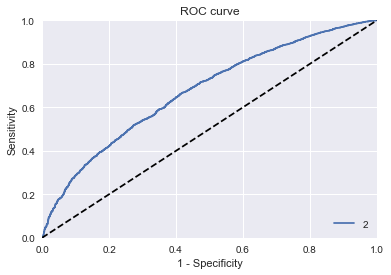

In [28]:
logistic_probs = logistic.predict_proba(X_val)[:,1]
calculate_roc_curve(Y_val, logistic_probs, 2)
print roc_auc_score(Y_val, logistic_probs)

confusion_matrix(Y_val, logistic_preds)

In [29]:
# workaround
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [30]:
# statsmodels for feature extraction
import statsmodels.api as sm
# from statsmodels.formula.api import logit
logit = sm.Logit(Y_train, X_train)
model = logit.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.392688
         Iterations 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                29754
Model:                          Logit   Df Residuals:                    29712
Method:                           MLE   Df Model:                           41
Date:                Mon, 05 Mar 2018   Pseudo R-squ.:                 0.07684
Time:                        17:04:30   Log-Likelihood:                -11684.
converged:                       True   LL-Null:                       -12657.
                                        LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
funded_amnt                          2.834e-06   1.51e-05      0.187      0.851   -2.68e-05    3.25e-05
term                                   -0.0197      0.003     -5.976      0.000      -0.026      -0.013
int_rate                               -0.1249      0.017     -7.246      0.000      -0.159      -0.091
installment                            -0.0001      0.001     -0.210      0.834      -0.001       0.001
grade                                  -0.0388      0.124     -0.313      0.755      -0.282       0.205
sub_grade                               0.0699      0.140      0.498      0.618      -0.205       0.345
emp_length                             -0.0181      0.005     -3.556      0.000      -0.028      -0.008
annual_inc                           5.634e-06   5.86e-07      9.612      0.000    4.49e-06    6.78e-06
dti                                    -0.0032      0.003     -1.086      0.277      -0.009       0.003
delinq_2yrs                            -0.0244      0.031     -0.783      0.434      -0.085       0.037
inq_last_6mths                         -0.1246      0.010    -12.103      0.000      -0.145      -0.104
open_acc                               -0.0019      0.005     -0.360      0.719      -0.012       0.009
pub_rec                                -0.0816      0.110     -0.745      0.456      -0.296       0.133
revol_bal                           -3.274e-06   8.55e-07     -3.828      0.000   -4.95e-06    -1.6e-06
revol_util                             -0.0033      0.001     -4.403      0.000      -0.005      -0.002
total_acc                               0.0023      0.002      1.024      0.306      -0.002       0.007
pub_rec_bankruptcies                   -0.2214      0.128     -1.729      0.084      -0.472       0.030
tax_liens                              33.9921   3.36e+07   1.01e-06      1.000   -6.58e+07    6.58e+07
has_employment                          0.7062      0.099      7.132      0.000       0.512       0.900
issue_month                             0.0070      0.005      1.346      0.178      -0.003       0.017
issue_year                              0.1210      0.023      5.299      0.000       0.076       0.166
earliest_cr_line_month                  0.0164      0.005      3.456      0.001       0.007       0.026
earliest_cr_line_year                   0.0012      0.000      8.200      0.000       0.001       0.001
home_ownership_NONE                    -1.0669      1.285     -0.830      0.406      -3.586       1.452
home_ownership_OTHER                   -0.3742      0.258     -1.451      0.147      -0.880       0.131
home_ownership_OWN                      0.0350      0.069      0.510      0.610      -0.100       0.170
home_ownership_RENT                    -0.0675      0.040     -1.687      0.092      -0.146       0.011
purpose_credit_card                     0.1635      0.111      1.476      0.140      -0.054       0.381
purpose_debt_cons

In [31]:
with open('logistic_output.tex', 'w') as f:
    f.write(model.summary().as_latex())

In [32]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf.fit(X_train, Y_train)
rf_preds = rf.predict(X_val)
rf_score = rf.score(X_val, Y_val)
rf_score

0.84990589711417819

In [33]:
rf_probs = rf.predict_proba(X_val)[:,1]
print roc_auc_score(Y_val, rf_probs)

confusion_matrix(Y_val, rf_preds)

0.697901251012


array([[   12,  1907],
       [    7, 10826]])

In [34]:
# ExtraTrees Classifier
et = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1)
et.fit(X_train, Y_train)
et_preds = et.predict(X_val)
et_score = et.score(X_val, Y_val)
et_score

0.84974905897114184

In [35]:
et_probs = et.predict_proba(X_val)[:,1]
print roc_auc_score(Y_val, et_probs)

confusion_matrix(Y_val, et_preds)

0.684815331072


array([[   21,  1898],
       [   18, 10815]])

In [36]:
# XGBoost
xgb = xgboost.XGBClassifier(n_estimators=100, n_jobs=-1, learning_rate=0.2)
xgb.fit(X_train, Y_train)
xgb_preds = xgb.predict(X_val)
xgb_score = xgb.score(X_val, Y_val)
xgb_score

0.84927854454203267

In [37]:
xgb_probs = xgb.predict_proba(X_val)[:,1]
print roc_auc_score(Y_val, xgb_probs)

confusion_matrix(Y_val, xgb_preds)

0.707819726718


array([[   36,  1883],
       [   39, 10794]])

In [38]:
# MLP (relu for now)
mlp = MLPClassifier(hidden_layer_sizes=(20, 10), activation='relu')
mlp.fit(X_train, Y_train)
mlp_preds = mlp.predict(X_val)
mlp_score = mlp.score(X_val, Y_val)
mlp_score

0.81297051442910917

In [39]:
mlp_probs = mlp.predict_proba(X_val)[:,1]
print roc_auc_score(Y_val, mlp_probs)

confusion_matrix(Y_val, mlp_preds)

0.589330860238


array([[  243,  1676],
       [  709, 10124]])

In [40]:
voters = [
#           ('et', ExtraTreesClassifier(n_estimators=1000, n_jobs=-1)),
          ('rf', RandomForestClassifier(n_estimators=1000, n_jobs=-1)),
          ('xgb', xgboost.XGBClassifier(n_estimators=100, n_jobs=-1)),
#           ('rf-b', RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')),
#           ('mlp', MLPClassifier(hidden_layer_sizes=(200, 100), activation='relu')),
         ]

In [41]:
voting_weights = np.array([ 
#                            et_score, 
                           rf_score, 
                           xgb_score,
#                            w_rf_score, mlp_score
                          ])

In [42]:
voting = VotingClassifier(estimators=voters, voting='soft', weights=list(voting_weights ** 1), n_jobs=-1)
voting.fit(X_train, Y_train)
voting_preds = voting.predict(X_val)
voting.score(X_val, Y_val)

0.84990589711417819

In [43]:
voting_probs = voting.predict_proba(X_val)[:,1]
print roc_auc_score(Y_val, voting_probs)

confusion_matrix(Y_val, voting_preds)

0.707911916992


array([[    9,  1910],
       [    4, 10829]])

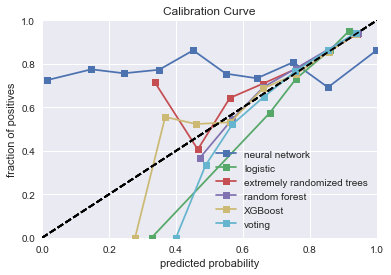

In [44]:
predictions = {'logistic': logistic_probs, 
               'random forest': rf_probs, 
               'extremely randomized trees': et_probs, 
               'XGBoost': xgb_probs,
               'neural network': mlp_probs, 
               'voting': voting_probs
              }
models = ['neural network', 'logistic', 'extremely randomized trees', 'random forest', 'XGBoost', 'voting']
for key in models:
    calculate_calibration_curve(Y_val, predictions[key], label=key)
plt.savefig('calibration_curve.pdf')
plt.show()

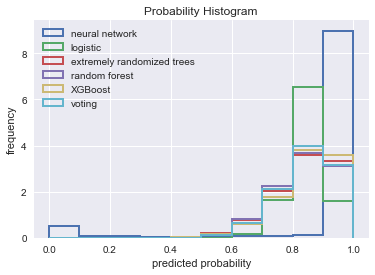

In [45]:
for key in models:
    calculate_prob_hist(predictions[key], label=key)
plt.savefig('prob_hist.pdf')
plt.show()

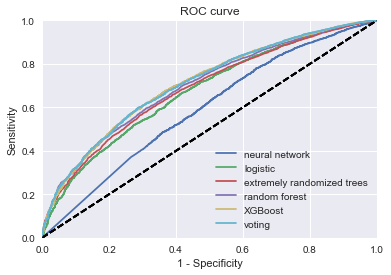

In [46]:
for key in models:
    calculate_roc_curve(Y_val, predictions[key], label=key)
plt.savefig('roc_curve.pdf')
plt.show()

In [47]:
for key in models:
    print(key, brier_score(Y_val, predictions[key]))
for key in models:
    print(key, log_likelihood(Y_val, predictions[key]))

('neural network', 0.1756109525971542)
('logistic', 0.12181844634894252)
('extremely randomized trees', 0.12126765487766586)
('random forest', 0.11969517558029973)
('XGBoost', 0.11842493712902069)
('voting', 0.11845883174829593)
('neural network', -inf)
('logistic', -0.4013520826737017)
('extremely randomized trees', -0.3963069407763708)
('random forest', -0.3913783692245016)
('XGBoost', -0.38765230774879456)
('voting', -0.3876758553261993)


/Users/richard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


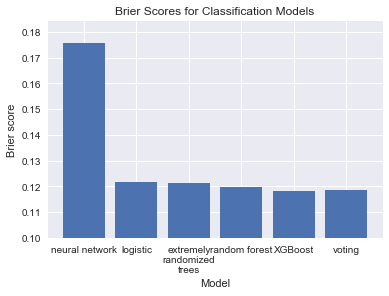

In [48]:
# data to plot
n_groups = len(models)
brier_score_list = [brier_score(Y_val, predictions[key]) for key in models]
 
# create plot
index = np.arange(n_groups)
 
plt.bar(index, brier_score_list, 
        label='Brier score')
 
models[2] = 'extremely\nrandomized\ntrees'
plt.xlabel('Model')
plt.ylabel('Brier score')
plt.ylim(ymin=0.1)
plt.title('Brier Scores for Classification Models')
plt.xticks(index, models)
 
plt.savefig('classification_brier.pdf')
plt.show()

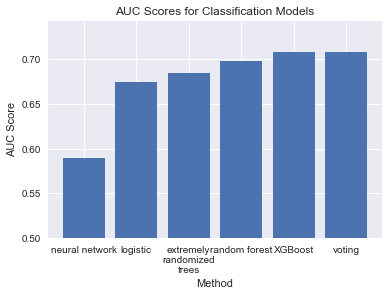

In [49]:
models[models.index('extremely\nrandomized\ntrees')] = 'extremely randomized trees'
auc_list = [roc_auc_score(Y_val, predictions[key]) for key in models]
 
# create plot
index = np.arange(len(models))
 
plt.bar(index, auc_list, 
        label='AUC')
 
models[2] = 'extremely\nrandomized\ntrees'
plt.xlabel('Method')
plt.ylabel('AUC Score')
plt.ylim(ymin=0.50)
plt.title('AUC Scores for Classification Models')
plt.xticks(index, models)

plt.savefig('classification_auc.pdf')
plt.show()

/Users/richard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


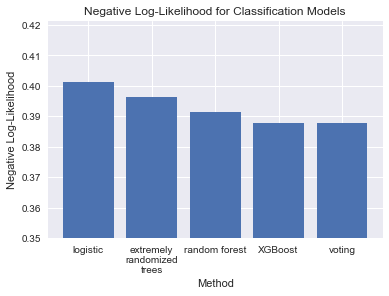

In [50]:
models.remove('neural network')
models[models.index('extremely\nrandomized\ntrees')] = 'extremely randomized trees'
log_likelihood_list = [-log_likelihood(Y_val, predictions[key]) for key in models]
 
# create plot
index = np.arange(len(models))
 
plt.bar(index, log_likelihood_list, 
         label='Negative Log-Likelihood')
 
models[1] = 'extremely\nrandomized\ntrees'
plt.xlabel('Method')
plt.ylabel('Negative Log-Likelihood')
plt.ylim(ymin=0.35)
plt.title('Negative Log-Likelihood for Classification Models')
plt.xticks(index, models)

plt.savefig('classification_loglik.pdf')
plt.show()

In [51]:
rf_scores = []
for n_trees in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:
    rf = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1)
    rf.fit(X_train, Y_train)
    rf_probs = rf.predict_proba(X_val)[:,1]
    rf_scores.append(roc_auc_score(Y_val, rf_probs))

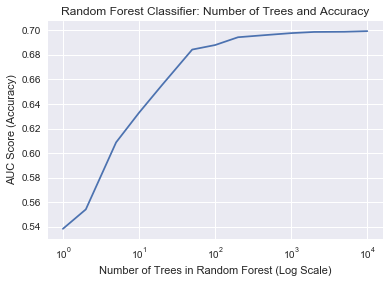

In [52]:
plt.semilogx([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000],
             rf_scores)
plt.xlabel('Number of Trees in Random Forest (Log Scale)')
plt.ylabel('AUC Score (Accuracy)')
plt.title('Random Forest Classifier: Number of Trees and Accuracy')
plt.savefig('num_trees_rfc.pdf')

In [53]:
xgb_scores = []
for n_trees in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
    xgb = xgboost.XGBClassifier(n_estimators=n_trees, n_jobs=-1)
    xgb.fit(X_train, Y_train)
    xgb_probs = xgb.predict_proba(X_val)[:,1]
    xgb_scores.append(roc_auc_score(Y_val, xgb_probs))

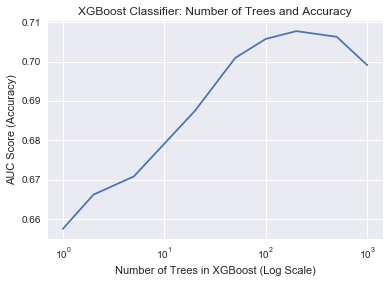

In [54]:
plt.semilogx([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
             xgb_scores)
plt.xlabel('Number of Trees in XGBoost (Log Scale)')
plt.ylabel('AUC Score (Accuracy)')
plt.title('XGBoost Classifier: Number of Trees and Accuracy')
plt.savefig('num_trees_xgbc.pdf')

# feature importances

In [55]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for i in range(X.shape[1]):
    print("%d & %s & %f \\\\" % (i + 1, X.columns[indices[i]], importances[indices[i]]))

Feature ranking:
1 & revol_bal & 0.111262 \\
2 & dti & 0.103542 \\
3 & annual_inc & 0.094005 \\
4 & installment & 0.092643 \\
5 & revol_util & 0.091129 \\
6 & int_rate & 0.064184 \\
7 & total_acc & 0.057675 \\
8 & earliest_cr_line_year & 0.056464 \\
9 & funded_amnt & 0.053134 \\
10 & open_acc & 0.036633 \\
11 & issue_month & 0.034060 \\
12 & earliest_cr_line_month & 0.028156 \\
13 & sub_grade & 0.027097 \\
14 & inq_last_6mths & 0.026037 \\
15 & emp_length & 0.022101 \\
16 & issue_year & 0.015138 \\
17 & delinq_2yrs & 0.011656 \\
18 & term & 0.006963 \\
19 & grade & 0.006812 \\
20 & purpose_small_business & 0.006206 \\
21 & pub_rec & 0.005147 \\
22 & purpose_major_purchase & 0.004390 \\
23 & purpose_credit_card & 0.004239 \\
24 & has_employment & 0.003784 \\
25 & purpose_other & 0.003633 \\
26 & verification_status_Verified & 0.003482 \\
27 & purpose_debt_consolidation & 0.003482 \\
28 & home_ownership_RENT & 0.003330 \\
29 & verification_status_Source Verified & 0.003028 \\
30 & purpos

In [56]:
df.columns

Index([u'funded_amnt', u'term', u'int_rate', u'installment', u'grade',
       u'sub_grade', u'emp_length', u'annual_inc', u'loan_status', u'dti',
       u'delinq_2yrs', u'inq_last_6mths', u'open_acc', u'pub_rec',
       u'revol_bal', u'revol_util', u'total_acc', u'pub_rec_bankruptcies',
       u'tax_liens', u'has_employment', u'issue_month', u'issue_year',
       u'earliest_cr_line_month', u'earliest_cr_line_year',
       u'home_ownership_NONE', u'home_ownership_OTHER', u'home_ownership_OWN',
       u'home_ownership_RENT', u'purpose_credit_card',
       u'purpose_debt_consolidation', u'purpose_educational',
       u'purpose_home_improvement', u'purpose_house',
       u'purpose_major_purchase', u'purpose_medical', u'purpose_moving',
       u'purpose_other', u'purpose_renewable_energy',
       u'purpose_small_business', u'purpose_vacation', u'purpose_wedding',
       u'verification_status_Source Verified',
       u'verification_status_Verified'],
      dtype='object')

# predicting the interest rate (regression)

## regression evaluation metrics

In [57]:
def mse(actual, predicted):
    return np.mean(np.square(actual - predicted))

def mae(actual, predicted):
    return np.mean(np.absolute(actual - predicted))

In [58]:
Y = df['int_rate']
X = df.drop(['int_rate', 'loan_status', 'grade', 'sub_grade', 'installment'], axis=1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)

In [59]:
# OLS from statsmodels
linear = sm.OLS(Y_train, X_train)
model = linear.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               int_rate   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 1.808e+04
Date:                Mon, 05 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:17:46   Log-Likelihood:                -70516.
No. Observations:               29754   AIC:                         1.411e+05
Df Residuals:                   29716   BIC:                         1.414e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
funded_amnt                             0.0001   2.64e-06     39.287      0.000    9.86e-05       0.000
term                                    0.1316      0.002     82.292      0.000       0.128       0.135
emp_length                             -0.0206      0.005     -4.521      0.000      -0.029      -0.012
annual_inc                           2.659e-07   2.49e-07      1.068      0.286   -2.22e-07    7.54e-07
dti                                    -0.0101      0.003     -3.909      0.000      -0.015      -0.005
delinq_2yrs                             1.2717      0.029     43.890      0.000       1.215       1.329
inq_last_6mths                          0.4612      0.010     44.479      0.000       0.441       0.481
open_acc                                0.1120      0.005     23.014      0.000       0.102       0.122
pub_rec                                 1.0478      0.110      9.566      0.000       0.833       1.262
revol_bal                            -8.72e-06   7.69e-07    -11.338      0.000   -1.02e-05   -7.21e-06
revol_util                              0.0588      0.001     98.559      0.000       0.058       0.060
total_acc                              -0.0519      0.002    -26.620      0.000      -0.056      -0.048
pub_rec_bankruptcies                   -0.0212      0.131     -0.162      0.871      -0.277       0.235
tax_liens                              -2.8243      2.594     -1.089      0.276      -7.908       2.260
has_employment                          0.4850      0.100      4.840      0.000       0.289       0.681
issue_month                            -0.0229      0.004     -5.148      0.000      -0.032      -0.014
issue_year                             -0.3829      0.018    -21.199      0.000      -0.418      -0.347
earliest_cr_line_month                 -0.0052      0.004     -1.230      0.219      -0.014       0.003
earliest_cr_line_year                   0.0024      0.000     20.766      0.000       0.002       0.003
home_ownership_NONE                    -0.6733      1.297     -0.519      0.604      -3.215       1.868
home_ownership_OTHER                    0.5898      0.267      2.209      0.027       0.066       1.113
home_ownership_OWN                      0.4904      0.060      8.156      0.000       0.373       0.608
home_ownership_RENT                     0.5888      0.036     16.550      0.000       0.519       0.659
purpose_credit_card                     0.1384      0.090      1.539      0.124      -0.038       0.315
purpose_debt_consolidation              0.5174      0.083      6.266      0.000       0.356       0.679
purpose_educational                     1.0435      0.173      6.016      0.000       0.704       1.383
purpose_home_improvement                0.7338      0.096      7.66

In [60]:
with open('linear_output.tex', 'w') as f:
    f.write(model.summary().as_latex())

In [61]:
# Linear Regression 
linear = LinearRegression()
linear.fit(X_train, Y_train)
linear_preds = linear.predict(X_val)
linear_score = linear.score(X_val, Y_val)
print linear_score

0.522076758326


In [62]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf.fit(X_train, Y_train)
rf_preds = rf.predict(X_val)
rf_score = rf.score(X_val, Y_val)
print rf_score

0.654380213349


In [63]:
# ExtraTrees Regressor
et = ExtraTreesRegressor(n_estimators=1000, n_jobs=-1)
et.fit(X_train, Y_train)
et_preds = et.predict(X_val)
et_score = et.score(X_val, Y_val)
print et_score

0.652413136388


In [64]:
# MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu')
mlp.fit(X_train, Y_train)
mlp_preds = mlp.predict(X_val)
mlp_score = mlp.score(X_val, Y_val)
print mlp_score

-292.479485509


In [65]:
# XGBoost
xgb = xgboost.XGBRegressor(n_estimators=10000, n_jobs=-1)
xgb.fit(X_train, Y_train)
xgb_preds = xgb.predict(X_val)
xgb_score = xgb.score(X_val, Y_val)
print xgb_score

0.671090035975


In [66]:
mse(Y_val, xgb_preds), mae(Y_val, xgb_preds)

(4.521580485098069, 1.6628228454308622)

In [67]:
voting_preds = (rf_preds * rf_score + xgb_preds * xgb_score) / (rf_score + xgb_score)
voting_score = np.corrcoef(Y_val, voting_preds)[0][1] ** 2
voting_score

0.69067987197574232

In [68]:
predictions = {'linear': linear_preds, 
               'random forest': rf_preds, 
               'extremely randomized trees': et_preds, 
               'XGBoost': xgb_preds,
               'voting': voting_preds}
models = ['linear', 'extremely randomized trees', 'random forest', 'XGBoost', 'voting']
for key in models:
    print(key, mse(Y_val, predictions[key]))
for key in models:
    print(key, mae(Y_val, predictions[key]))

('linear', 6.5700910257768195)
('extremely randomized trees', 4.778322826533892)
('random forest', 4.751322547796977)
('XGBoost', 4.521580485098069)
('voting', 4.26281685393634)
('linear', 2.038644192291951)
('extremely randomized trees', 1.721914699654956)
('random forest', 1.708374029171889)
('XGBoost', 1.6628228454308622)
('voting', 1.612250099517484)


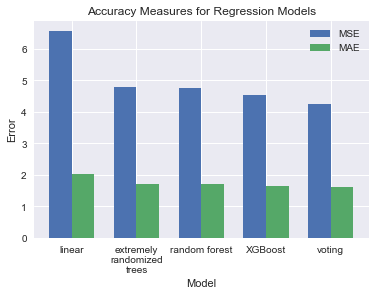

In [69]:
n_groups = len(models)
mse_list = [mse(Y_val, predictions[key]) for key in models]
mae_list = [mae(Y_val, predictions[key]) for key in models]
 
# create plot
index = np.arange(n_groups)
bar_width = 0.35
 
plt.bar(index, mse_list, bar_width,
        label='MSE')
plt.bar(index + bar_width, mae_list, bar_width,
        label='MAE')
 
models[1] = 'extremely\nrandomized\ntrees'
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Accuracy Measures for Regression Models')
plt.xticks(index + bar_width / 2., models)
plt.legend()
 
plt.savefig('regression_errors.pdf')
plt.show()

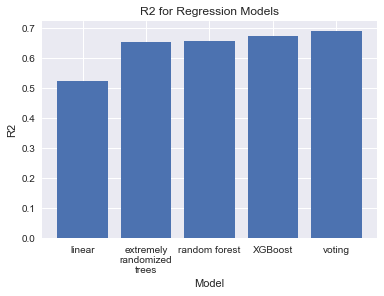

In [70]:
models[models.index('extremely\nrandomized\ntrees')] = 'extremely randomized trees'
r2_list = [np.corrcoef(Y_val, predictions[key])[0][1] ** 2 for key in models]
 
# create plot
index = np.arange(n_groups)
 
plt.bar(index, r2_list, 
        label='R2')
 
models[1] = 'extremely\nrandomized\ntrees'
plt.xlabel('Model')
plt.ylabel('R2')
plt.title('R2 for Regression Models')
plt.xticks(index, models)

plt.savefig('regression_r2.pdf')
plt.show()

## feature importances (regression)

In [71]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for i in range(X.shape[1]):
    print("%d & %s & %f \\\\" % (i + 1, X.columns[indices[i]], importances[indices[i]]))

Feature ranking:
1 & revol_bal & 0.191499 \\
2 & dti & 0.139773 \\
3 & annual_inc & 0.119394 \\
4 & revol_util & 0.101881 \\
5 & funded_amnt & 0.093779 \\
6 & total_acc & 0.052802 \\
7 & earliest_cr_line_year & 0.047900 \\
8 & open_acc & 0.042344 \\
9 & issue_month & 0.033703 \\
10 & earliest_cr_line_month & 0.028161 \\
11 & emp_length & 0.023943 \\
12 & inq_last_6mths & 0.021485 \\
13 & issue_year & 0.020568 \\
14 & delinq_2yrs & 0.010197 \\
15 & term & 0.008160 \\
16 & purpose_debt_consolidation & 0.006502 \\
17 & verification_status_Verified & 0.004917 \\
18 & home_ownership_RENT & 0.004917 \\
19 & purpose_credit_card & 0.004742 \\
20 & verification_status_Source Verified & 0.004524 \\
21 & purpose_small_business & 0.003986 \\
22 & purpose_home_improvement & 0.003753 \\
23 & purpose_other & 0.003462 \\
24 & purpose_wedding & 0.003317 \\
25 & pub_rec & 0.003171 \\
26 & home_ownership_OWN & 0.002996 \\
27 & purpose_major_purchase & 0.002866 \\
28 & purpose_medical & 0.002386 \\
29 & p

## hyperparameter tuning (regression)

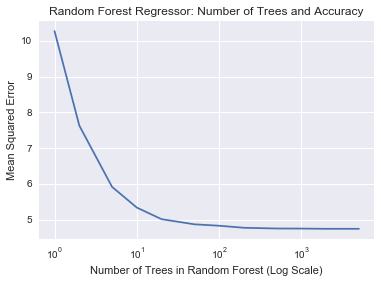

In [77]:
rf_scores = []
for n_trees in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]:
    rf = RandomForestRegressor(n_estimators=n_trees, n_jobs=-1)
    rf.fit(X_train, Y_train)
    rf_preds = rf.predict(X_val)
    rf_scores.append(mse(Y_val, rf_preds))

plt.semilogx([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000],
             rf_scores)
plt.xlabel('Number of Trees in Random Forest (Log Scale)')
plt.ylabel('Mean Squared Error')
plt.title('Random Forest Regressor: Number of Trees and Accuracy')
plt.savefig('num_trees_rfr.pdf')

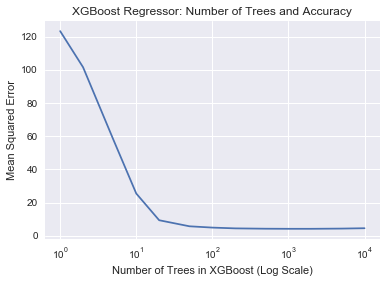

In [79]:
xgb_scores = []
for n_trees in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:
    xgb = xgboost.XGBRegressor(n_estimators=n_trees, n_jobs=-1)
    xgb.fit(X_train, Y_train)
    xgb_preds = xgb.predict(X_val)
    xgb_scores.append(mse(Y_val, xgb_preds))

plt.semilogx([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000],
             xgb_scores)
plt.xlabel('Number of Trees in XGBoost (Log Scale)')
plt.ylabel('Mean Squared Error')
plt.title('XGBoost Regressor: Number of Trees and Accuracy')
plt.savefig('num_trees_xgbr.pdf')